# Data Curation

The goal of this project is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through September 30 2018, while following the best practices for open scientific research in design and implementation, and making it fully reproducible.

I have combined data about Wikipedia page traffic from two different Wikimedia REST API endpoints into a single dataset, performed some simple data processing steps on the data, and then analyzed that data.

The reference readings are:
  1. [Assessing Reproducibility](https://www.practicereproducibleresearch.org/core-chapters/2-assessment.html)
  2. [The Basic Reproducible Workflow Template](https://www.practicereproducibleresearch.org/core-chapters/3-basic.html)
  

#### Import Libraries

In [227]:
import numpy as np
import pandas as pd
import requests
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## 1. Data acquisition

#### Parameters for Legacy API for Pagecounts

In [228]:
params_legacy_desktop = {
    "project": "en.wikipedia.org",
    "access-site": "desktop-site",
    "granularity": "monthly",
    "start": "2008010100",
    "end": "2018093000"
}

params_legacy_mobile = {
    "project": "en.wikipedia.org",
    "access-site": "mobile-site",
    "granularity": "monthly",
    "start": "2008010100",
    "end": "2018093000"
}

#### Legacy API call for Pagecounts

API endpoint for Legacy pagecounts

In [229]:
legacy_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'


API calls for desktop and mobile views. 
Data obtained is saved in json files with name format of "apiname_accesstype_firstmonth-lastmonth.json"

In [230]:
api_call = requests.get(legacy_endpoint.format(**params_legacy_desktop))
pagecounts_desktop = api_call.json()
with open('pagecounts_desktop-site_200801-201809', 'w') as f:
    json.dump(pagecounts_desktop, f)
    
api_call = requests.get(legacy_endpoint.format(**params_legacy_mobile))
pagecounts_mobile = api_call.json()
with open('pagecounts_mobile-site_200801-201809', 'w') as f:
    json.dump(pagecounts_mobile, f)

#### Parameters for Pageviews API

In [231]:
params_pageviews_desktop = {
    "project": "en.wikipedia.org",
    "access-site": "desktop",
    "agent": "user",
    "granularity": "monthly",
    "start": "2008010100",
    "end": "2018093000"
}

params_pageviews_mobile = {
    "project": "en.wikipedia.org",
    "access-site": "mobile-web",
    "agent": "user",
    "granularity": "monthly",
    "start": "2008010100",
    "end": "2018093000"
}

params_pageviews_mobileapp = {
    "project": "en.wikipedia.org",
    "access-site": "mobile-app",
    "agent": "user",
    "granularity": "monthly",
    "start": "2008010100",
    "end": "2018093000"
}

#### API call for Pageviews

API endpoint for Pageviews

In [232]:
pageviews_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access-site}/{agent}/{granularity}/{start}/{end}'


API calls for desktop, mobile, and mobileapp views. 
Data obtained is saved in json files with name format of "apiname_accesstype_firstmonth-lastmonth.json"

In [233]:
api_call = requests.get(pageviews_endpoint.format(**params_pageviews_desktop))
pageviews_desktop = api_call.json()
with open('pageviews_desktop-site_200801-201809', 'w') as f:
    json.dump(pageviews_desktop, f)
    
api_call = requests.get(pageviews_endpoint.format(**params_pageviews_mobile))
pageviews_mobile = api_call.json()
with open('pageviews_mobile-site_200801-201809', 'w') as f:
    json.dump(pageviews_mobile, f)
    
api_call = requests.get(pageviews_endpoint.format(**params_pageviews_mobileapp))
pageviews_mobileapp = api_call.json()
with open('pageviews_mobile-app_200801-201809', 'w') as f:
    json.dump(pageviews_mobileapp, f)

## 2. Data Processing

First of all, convert the objects returned by the API calls to Pandas dataframe.

In [234]:
pagecounts_df1 = pd.DataFrame(pagecounts_desktop['items'])
pagecounts_df2 = pd.DataFrame(pagecounts_mobile['items'])

pageviews_df1 = pd.DataFrame(pageviews_desktop['items'])
pageviews_df2 = pd.DataFrame(pageviews_mobile['items'])
pageviews_df3 = pd.DataFrame(pageviews_mobileapp['items'])

For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.

In [235]:
pageviews_df2['views'] = pageviews_df2['views'] + pageviews_df3['views']
pageviews_df2['access'] = 'mobile'

Get all dataframes in a list.

In [236]:
list_of_dataframes = []

list_of_dataframes.append(pagecounts_df1)
list_of_dataframes.append(pagecounts_df2)
list_of_dataframes.append(pageviews_df1)
list_of_dataframes.append(pageviews_df2)

For every dataframe, convert the timestamp column to two columns, namely, year and month. Discard the day and time. Then drop the granularity, project, timestamp and, agent columns.

In [237]:
for df in list_of_dataframes:
 
    df.drop(['granularity', 'project'], axis=1, inplace=True)
    df['year'] = df['timestamp'].apply(lambda x: x[:4])
    df['month'] = df['timestamp'].apply(lambda x: x[4:6])
    df.drop(['timestamp'], axis=1, inplace=True)
    
    if 'views' in df.columns:
        df = df.drop(['agent'], axis=1, inplace=True)  

Initialize an empty dataframe final_df with the columns required in the final result. This dataframe will hold the final processed data.

In [238]:
col_names = ['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
            'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
final_df  = pd.DataFrame(columns = col_names)

Generate the dataframe with data from Jan, 2008 till Sept, 2019. For every month, get the pagecount desktop views, pagecount mobile views, pagecount desktop views, and, pagecount mobile views.

In [239]:
row_index = 0
for year in np.arange(2008, 2019):
    y_str = str(year)
    
    for month in np.arange(1,13):
        
        if month > 9: 
            m_str = str(month) 
        else: 
            m_str = '0'+ str(month)
        
        final_df.at[row_index, 'year'] = y_str
        final_df.at[row_index, 'month'] = m_str
        
        for i, df in enumerate(list_of_dataframes):
         
            locate_date_df = df.loc[(df['year'] == y_str) & (df['month'] == m_str)]
            
            if locate_date_df.empty:
                counts_or_views = 0
                if i == 0:
                    final_df.at[row_index, 'pagecount_desktop_views'] = counts_or_views
                elif i==1:
                    final_df.at[row_index, 'pagecount_mobile_views'] = counts_or_views
                elif i==2:
                    final_df.at[row_index, 'pageview_desktop_views'] = counts_or_views
                else:
                    final_df.at[row_index, 'pageview_mobile_views'] = counts_or_views
            else:
                if 'count' in locate_date_df.columns:
                    counts_or_views = locate_date_df['count'].values[0]
                else:
                    counts_or_views = locate_date_df['views'].values[0]
                    
                if i == 0:
                    final_df.at[row_index, 'pagecount_desktop_views'] = counts_or_views
                elif i==1:
                    final_df.at[row_index, 'pagecount_mobile_views'] = counts_or_views
                elif i==2:
                    final_df.at[row_index, 'pageview_desktop_views'] = counts_or_views
                else:
                    final_df.at[row_index, 'pageview_mobile_views'] = counts_or_views
                
        row_index = row_index + 1



Add the pagecount desktop and mobile views to get all pagecount views. Similarly, add pageviews desktop and mobile views to get all pageviews.

In [240]:
final_df['pagecount_all_views'] = final_df['pagecount_desktop_views'] + final_df['pagecount_mobile_views']
final_df['pageview_all_views'] = final_df['pageview_desktop_views'] + final_df['pageview_mobile_views']


Remove the last 3 rows denoting the last months of 2018 from the dataframe.

Make and save a csv file from the dataframe.

Print the head of the dataframe.

In [241]:
final_df = final_df[:-3]
final_df.to_csv('en-wikipedia_traffic_200801-201809.csv', index=False)
final_df.head(5)

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4930902570,4930902570,0,0,0,0
1,2008,02,4818393763,4818393763,0,0,0,0
2,2008,03,4955405809,4955405809,0,0,0,0
3,2008,04,5159162183,5159162183,0,0,0,0
4,2008,05,5584691092,5584691092,0,0,0,0


## 3. Analysis

#### The time series graph will track three traffic metrics: 
1. mobile traffic
2. desktop traffic
3. all traffic (mobile + desktop)

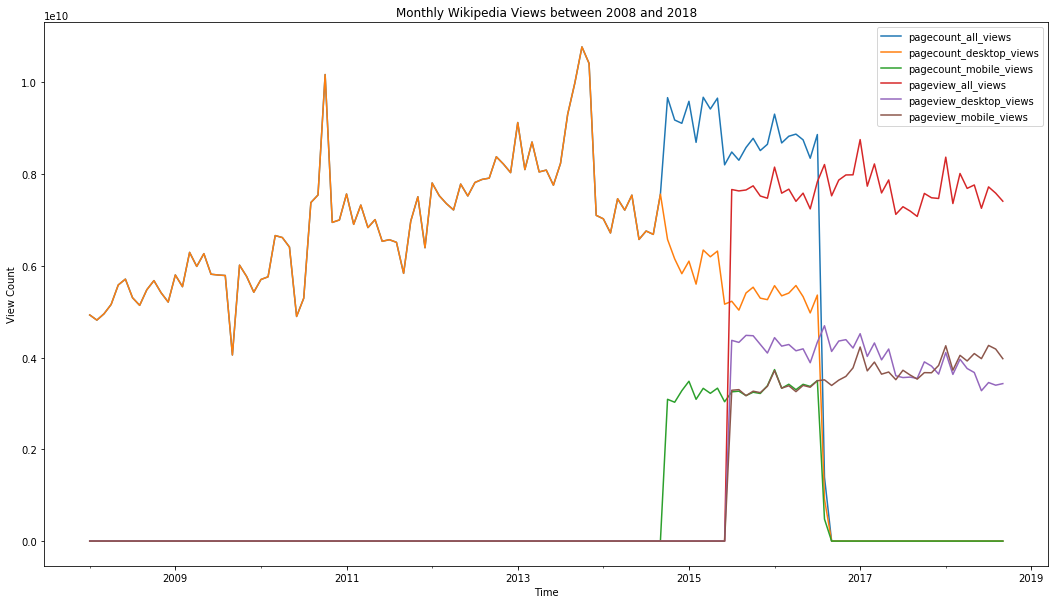

In [243]:
final_df.index = pd.date_range(freq='M', start='2008-01-01', end='2018-10-01')
df_plot = final_df.plot(title='Monthly Wikipedia Views between 2008 and 2018')
df_plot.set_xlabel("Time")
df_plot.set_ylabel("View Count")
viz = df_plot.get_figure()
viz.set_size_inches(18, 10)

plt.savefig('monthly_wikipedia_views_plot.png')